In [370]:
%matplotlib inline
import IPython
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio
import pyaudio

#### Utilities

In [371]:
def waveform(ampl):
    if ampl < 0: 
        return 1
    if ampl > 0:
        return 3

In [372]:
def signal(pattern, pulse):
    pulse = np.array(pulse);
    return np.array([waveform(ampl) * pulse for ampl in pattern]).flatten()

In [373]:
def match_decoder(signal, pulse, dt_sampling, decision):
    match = np.convolve(signal, pulse[::-1])
    samples = match[np.arange(0, len(match), dt_sampling)]
    print(samples)
    return [decision(s) for s in samples]

In [374]:
def binarize(text):
    return [int(b) for c in text for b in "{0:08b}".format(ord(c))]

In [375]:
def textarize(binary):
    bin_str = [str(b) for b in binary]
    bin_chunks = ["".join(bin_str[c:c+8]) for c in range(0, len(bin_str), 8)]
    return "".join([chr(int(c, 2)) for c in bin_chunks])

#### Shared parameters

In [457]:
rate = 8192
max_t = rate * 15 # 15s
t = 1/rate

dt_sampling = 100
pulse = np.sinc(np.linspace(-dt_sampling/2, dt_sampling/2, dt_sampling))

delim = np.zeros(80) # alternating -1/1
delim[0::2] = 1
delim[1::2] = -1

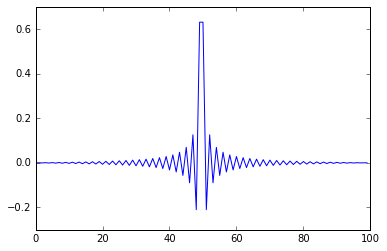

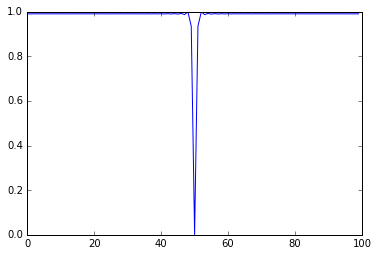

In [377]:
plt.plot(pulse)
plt.show()
plt.plot(abs(np.fft.fft(pulse)))
plt.show()
plt.show()

Audio(pulse, rate=rate)


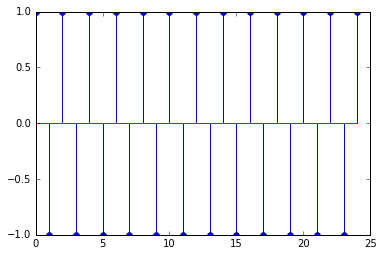

In [378]:
plt.stem(delim)
plt.show()

#### Emitter

In [379]:
d = "The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)"
len(d)

137

In [380]:
d_bin = binarize(d)
assert d == textarize(d_bin)
d_code = [1 if x == 0 else -1 for x in d_bin]
len(d_code)

1096

In [381]:
dt_origin = 756

s_delay = np.zeros(dt_origin)
s_delim = signal(delim, pulse)
s_data = signal(d_code, pulse)

s = np.concatenate((s_delay, s_delim, s_data))

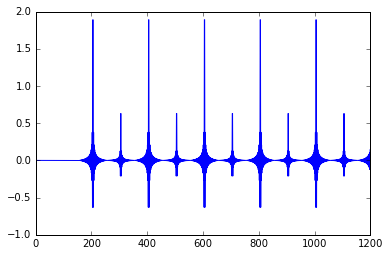

In [382]:
plt.plot(s[600:1800])
plt.show()

In [383]:
Audio(s_data, rate=rate)

#### Channel

In [384]:
c_rate, c = wavfile.read("interference.wav")
assert rate == c_rate
Audio(c, rate=rate)

In [444]:
c_mean = np.mean(c)
c_std = np.std(c)
s_ampl = c_std * 1

In [445]:
s_n = s * s_ampl + c[:len(s)] + s_ampl
Audio(s_n, rate=rate)

In [387]:
sn = s_n

#### Receiver

In [458]:
xcorr = np.correlate(sn, s_delim)
dt_delay = np.argmax(xcorr)

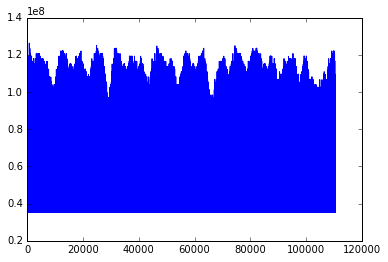

756


In [461]:
plt.plot(xcorr)
plt.show()
print(dt_delay)

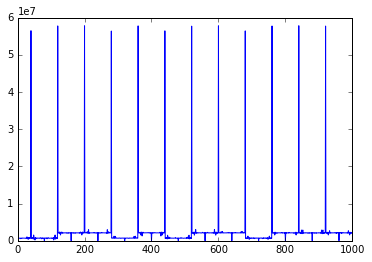

[  637.99820916  2629.48273369  2000.90388865  2001.98697985  3253.12029092
  1723.03151826  2265.6061978   2321.10408346  2328.64293629  2592.09426924
  2023.95298213  2021.12590826  3213.68621049  1760.8550581   2286.39862418
  2313.74506237  2312.31652742  2646.73122212  2009.33366752  2002.02191356
  3263.17026889  2622.78663804  1998.52294452  1997.98430267  3247.12982241
  1719.57745396  2893.74598387  2934.63487409  2309.83915181  1731.43861543
  2292.5914551   2333.99378223  3520.88238872  2966.83149688  2284.2263498
  1389.93077566  3230.58598881  2643.15896854  2007.37698171  2004.03001625
  3265.96813665  2617.17485972  1995.30539422  2921.43566115  3554.07392341
  2912.73686411  2900.05864338  2015.46489863  2028.52216526  2606.40286568
  1401.8970617   2328.84166561  2308.63213335  2646.92484315  1391.67217831
  2312.50177208  3513.64352304  1759.18834822  2272.12330464  2322.98499375
  2329.8498475   1736.16796929  2882.51607604  1994.73252591  3247.04564097
  2913.310197

In [470]:
r_shift = sn[dt_delay:] - s_ampl
r_transf = np.empty(0)
for i in range(0,len(r_shift), dt_sampling):
    r_transf = np.concatenate((r_transf, abs(np.fft.fft(r_shift[i + 10 :i+dt_sampling -10]))));
    
plt.plot(r_transf[3400:4400])
plt.show()

r_align = match_decoder(r_transf, abs(np.fft.fft(pulse)) / len(r_transf), dt_sampling, lambda x: -1 if x < 1000 else 1)
r_code = r_align[len(delim):]

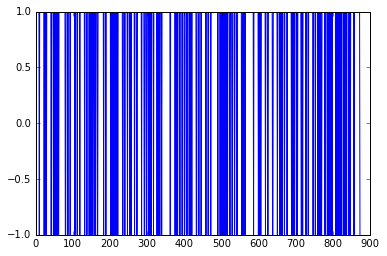

In [437]:
plt.plot(r_code)
plt.show()

In [456]:
r = [0 if x == 1 else 1 for x in r_code]

r_str = textarize(r[:])
print(d)
print(r_str)

print(d_bin[:])
#print(r[1:25])

#for i in range(0, 1000):
    #print(d_bin[i], ' ', r[i])

#plt.plot(np.correlate(r, d_bin))
#plt.show()

The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)
                                                                                                             
[0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 

In [455]:
def longest_common_substring(s1, s2):
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

t1 = "".join([str(c) for c in d_bin])
t2 = "".join([str(c) for c in r])
longest_common_substring(t1, t2)

'00000001'

#### Record

In [446]:
ex_chunk = 1024
ex_format = pyaudio.paInt32
ex_channel = 2
ex_sec = 15

p = pyaudio.PyAudio()
stream = p.open(format=ex_format, channels=ex_channel, rate=rate, input=True, frames_per_buffer=ex_chunk)
buf = []

for i in range(0, int(rate / ex_chunk * ex_sec)):
    data = stream.read(ex_chunk)
    buf.append(np.fromstring(data, 'Int32'))

stream.stop_stream()
stream.close()
p.terminate()

ex_chan = np.array(buf).flatten()
ex_group = np.reshape(ex_chan, [len(ex_chan) / ex_channel, ex_channel])
ex = [np.average(g) for g in ex_group]
assert len(ex) == len(ex_chan) / ex_channel

In [447]:
Audio(ex, rate=rate)

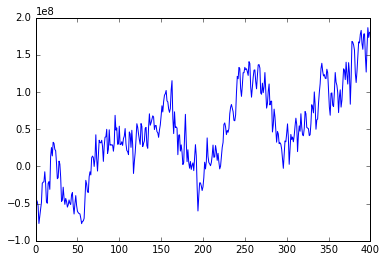

In [448]:
plt.plot(ex[3000:3400])
plt.show()

In [397]:
sn = ex

#### Todos

- amplitude bounds (100Hz - 20KHz)
- mean noise subtraction
- find best amplitude
- lowerpass match
- block with parity checks


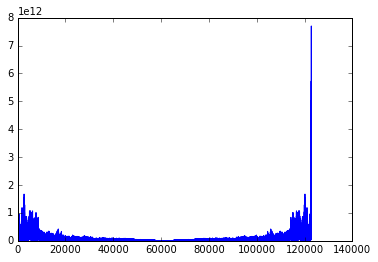

In [398]:
plt.plot(abs(np.fft.fft(ex)))
plt.show()

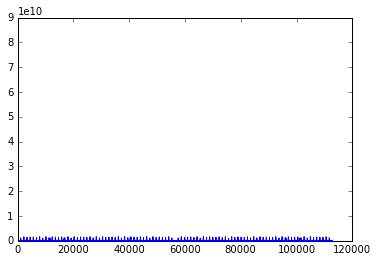

In [399]:
plt.plot(abs(np.fft.fft(s_n)))
plt.show()

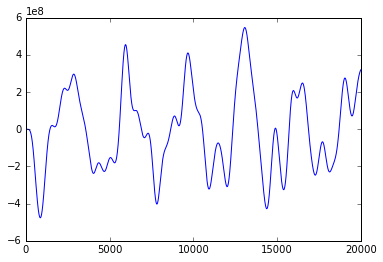

In [400]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

cutoff = 10
order = 6

b, a = butter_lowpass(cutoff, rate, order)
y = lfilter(b, a, ex)
plt.plot(y[0:20000])
plt.show()

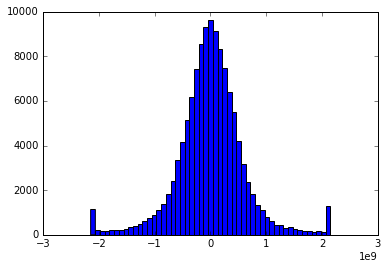

In [401]:
plt.hist(ex, bins=51)
sn = s_n
plt.show()

In [402]:
min(ex)

-2147483648.0

In [403]:
max(ex)

2147483647.0

In [404]:
np.average(ex)

-5335097.3808512371

In [405]:
np.average(s_n)

734535.03869808337

In [406]:
t = signal(delim + 2, pulse)
Audio(t, rate=rate)

In [407]:
delim

array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.])

In [408]:
T = 10
t = np.linspace(0, T, int(T * rate))
s_440 = np.sin(2 * np.pi * 440 * t)
s_261 = np.sin(2 * np.pi * 261.63 * t)

In [409]:
Audio(s_440, rate=rate)

In [410]:
Audio(s_261, rate=rate)

In [411]:
s_mix = s_440 * 1000 + s_261 * 500
Audio(s_mix, rate=rate)

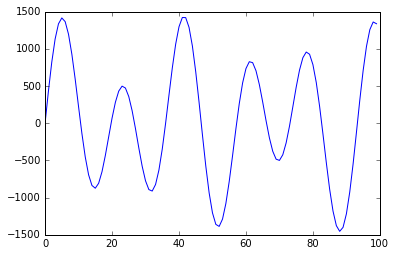

In [412]:
plt.plot(s_mix[:100])

In [413]:
def record(sec, rate):
    ex_chunk = 1024
    ex_format = pyaudio.paInt32
    ex_channel = 2

    p = pyaudio.PyAudio()
    stream = p.open(format=ex_format, channels=ex_channel, rate=rate, input=True, frames_per_buffer=ex_chunk)
    buf = []

    for i in range(0, int(rate / ex_chunk * sec)):
        data = stream.read(ex_chunk)
        buf.append(np.fromstring(data, 'Int32'))

    stream.stop_stream()
    stream.close()
    p.terminate()

    ex_chan = np.array(buf).flatten()
    ex_group = np.reshape(ex_chan, [len(ex_chan) / ex_channel, ex_channel])
    ex = [np.average(g) for g in ex_group]
    assert len(ex) == len(ex_chan) / ex_channel
    
    return ex

In [414]:
recorded = record(5, rate)

In [415]:
Audio(recorded, rate=rate)

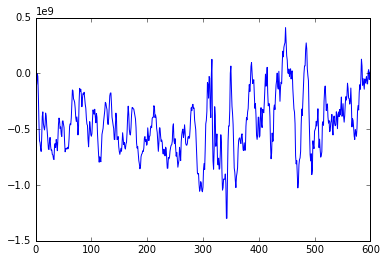

In [432]:
plt.plot(recorded[900:1500])